In [2]:
# Predict high risk areas 

# Import libraries

import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from geopandas.tools import sjoin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN
from sklearn.utils.class_weight import compute_class_weight
import shap

# Load
hex_totalscore = gpd.read_file('../data/hex_totalscore.shp')
centrality_measures = pd.read_csv('../data/network_centrality_measures.csv')
accidents = gpd.read_file('../data/accidents_trento.geojson')
hex_totalscore.drop(columns=['index'], inplace=True)
# Set 'geometry' as the geometry column
hex_totalscore = hex_totalscore.set_geometry('geometry')
hex_totalscore = hex_totalscore.set_crs("EPSG:25832", allow_override=True) 

# Convert 'coordinates' column to Shapely Point objects
def create_point(row):
    x, y = map(float, row['coordinates'].strip('()').split(', '))
    return Point(x, y)
centrality_measures['geometry'] = centrality_measures.apply(create_point, axis=1)
centrality_gdf = gpd.GeoDataFrame(centrality_measures, geometry='geometry')
centrality_gdf = centrality_gdf.set_crs("EPSG:25832", allow_override=True) 

# Filter accidents for years >= 2018
accidents_filtered = accidents[accidents['anno'] >= 2018].copy()
accidents_filtered['anno'] = accidents_filtered['anno'].astype(int)
accidents_simplified = gpd.GeoDataFrame(accidents_filtered[['anno', 'geometry']])

joined = gpd.sjoin(hex_totalscore, accidents_simplified, how='left', predicate='contains')
accident_counts = joined.groupby(joined.index).size()
accident_counts_df = pd.DataFrame(accident_counts, columns=['accidents_count'])
hex_totalscore_with_accidents = hex_totalscore.merge(accident_counts_df, left_index=True, right_index=True, how='left')
hex_totalscore_with_accidents['accidents_count'] = hex_totalscore_with_accidents['accidents_count'].fillna(0).astype(int)

#print(hex_totalscore_with_accidents['accidents_count'].value_counts())

# This joins the centrality data to the hexagons they fall within
joined_with_centrality = gpd.sjoin(hex_totalscore_with_accidents, centrality_gdf, how='left', predicate='contains')

# Group by the hexagon index and calculate means
centrality_means = joined_with_centrality.groupby(joined_with_centrality.index).agg({
    'degree_centrality': 'mean',
    'betweenness_centrality': 'mean',
    'closeness_centrality': 'mean'
})

# Rename columns
centrality_means.columns = ['degree_centrality_mean', 'betweenness_centrality_mean', 'closeness_centrality_mean']

# Merge the centrality means back into the original hex_totalscore_with_accidents DataFrame
hex_totalscore_with_centrality = hex_totalscore_with_accidents.merge(centrality_means, left_index=True, right_index=True, how='left')

# Fill NaN values with 0 (assuming no centrality data in those hexagons)
hex_totalscore_with_centrality.fillna(0, inplace=True)

df = hex_totalscore_with_centrality.copy()

In [77]:
# Assuming 'accidents_count' is the target variable. 
# You might want to categorize this into 'high-risk' (1) and 'low-risk' (0) based on a threshold.

# Define the threshold for high-risk and low-risk categorization
percentile_threshold = 85  # Top 15%
threshold = df['accidents_count'].quantile(percentile_threshold / 100)  
df['risk_category'] = (df['accidents_count'] > threshold).astype(int)

# Selecting features for the model
features = ['total_scor', 'degree_centrality_mean', 'betweenness_centrality_mean', 'closeness_centrality_mean']
X = df[features]
y = df['risk_category']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Addressing Data Imbalance with Borderline-SMOTE
smote_methods = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)  
}

# Adjusting class weights for models
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights = {i: class_weights[i] for i in range(len(class_weights))}

# Parameter grid for GridSearchCV
param_grid = {
    'logreg': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    },
    'rfc': {
        'n_estimators': [10, 50, 100, 200],
        'max_features': ['sqrt', 'log2']
    },
    'svm': {
        'C': [0.01, 0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly']
    }
}

# Initialize models with balanced class weights
models = {
    'logreg': LogisticRegression(class_weight=weights),
    'rfc': RandomForestClassifier(class_weight=weights),
    'svm': SVC(class_weight=weights, probability=True)
}

# Applying GridSearchCV for hyperparameter tuning with cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for smote_key in smote_methods.keys():
    X_train_smote, y_train_smote = smote_methods[smote_key].fit_resample(X_train, y_train)
    print(f"Using {smote_key} resampling technique:")
    for model_key in models.keys():
        grid_search = GridSearchCV(models[model_key], param_grid[model_key], cv=skf, scoring='roc_auc')
        grid_search.fit(X_train_smote, y_train_smote)
        models[model_key] = grid_search.best_estimator_
        print(f"Best parameters for {model_key}: {grid_search.best_params_}")

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    auc_score = auc(recall, precision)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print("Precision-Recall AUC:", auc_score)
    print("ROC-AUC Score:", roc_auc)

# Evaluate models
for model_key in models.keys():
    print(f"Evaluating {model_key}:")
    evaluate_model(models[model_key], X_test, y_test)

Using SMOTE resampling technique:
Best parameters for logreg: {'C': 0.1, 'solver': 'liblinear'}
Best parameters for rfc: {'max_features': 'sqrt', 'n_estimators': 200}
Best parameters for svm: {'C': 10, 'kernel': 'rbf'}
Using ADASYN resampling technique:
Best parameters for logreg: {'C': 0.1, 'solver': 'lbfgs'}
Best parameters for rfc: {'max_features': 'sqrt', 'n_estimators': 200}
Best parameters for svm: {'C': 10, 'kernel': 'rbf'}
Using BorderlineSMOTE resampling technique:
Best parameters for logreg: {'C': 0.1, 'solver': 'lbfgs'}
Best parameters for rfc: {'max_features': 'sqrt', 'n_estimators': 200}
Best parameters for svm: {'C': 10, 'kernel': 'rbf'}
Using SMOTEENN resampling technique:
Best parameters for logreg: {'C': 0.1, 'solver': 'lbfgs'}
Best parameters for rfc: {'max_features': 'sqrt', 'n_estimators': 100}
Best parameters for svm: {'C': 10, 'kernel': 'rbf'}
Evaluating logreg:
              precision    recall  f1-score   support

           0       0.98      0.67      0.79     

Given the differences in precision and recall across models, the choice of the best model may depend on what is more critical for your application: reducing false positives or false negatives. If it's more important to not miss high-risk areas, logreg might be preferable despite its lower precision. If a balance is needed, rfc seems a better choice.

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       261
           1       0.55      0.83      0.66        36

    accuracy                           0.90       297
   macro avg       0.76      0.87      0.80       297
weighted avg       0.92      0.90      0.90       297

Confusion Matrix:
 [[236  25]
 [  6  30]]
Precision-Recall AUC: 0.7307519420365396
ROC-AUC Score: 0.8992124308216262


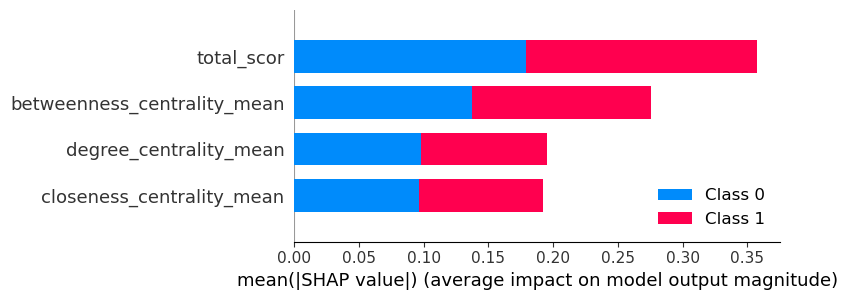

In [78]:
#Retrain on the full dataset

# Re-running the Random Forest Classifier on the full dataset
best_params_rfc = {'max_features': 'sqrt', 'n_estimators': 100}  # Use the best parameters from GridSearchCV

# Initialize the Random Forest model with the best parameters
rfc_model = RandomForestClassifier(max_features=best_params_rfc['max_features'], 
                                   n_estimators=best_params_rfc['n_estimators'],
                                   class_weight=weights, random_state=42)

# Since you are running the model on the full dataset, use the SMOTE method that performed best
smote_method = SMOTE(random_state=42)  # Replace with the SMOTE method that worked best for you
X_train_smote, y_train_smote = smote_method.fit_resample(X_train, y_train)

# Fit the model
rfc_model.fit(X_train_smote, y_train_smote)

# Predictions and Evaluation
predictions = rfc_model.predict(X_test)
print(classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
precision, recall, _ = precision_recall_curve(y_test, rfc_model.predict_proba(X_test)[:, 1])
auc_score = auc(recall, precision)
roc_auc = roc_auc_score(y_test, rfc_model.predict_proba(X_test)[:, 1])
print("Precision-Recall AUC:", auc_score)
print("ROC-AUC Score:", roc_auc)

# Using SHAP for model interpretation
explainer = shap.TreeExplainer(rfc_model)
shap_values = explainer.shap_values(X_train_smote)

# Plot summary
shap.summary_plot(shap_values, X_train_smote, feature_names=features)

In [91]:
# Predict the risk categories for the entire dataset
df['predicted_risk_category'] = rfc_model.predict(scaler.transform(df[features]))

# Merging the predictions back into the original geospatial dataset
hex_totalscore_with_predictions = hex_totalscore.merge(df[['predicted_risk_category']], left_index=True, right_index=True, how='left')

# Fill NaN values for areas that were not included in the prediction (if any)
hex_totalscore_with_predictions['predicted_risk_category'].fillna(0, inplace=True)

hex_totalscore_with_predictions = hex_totalscore_with_predictions.to_crs(epsg=4326)


import folium

# Convert your geodataframe to GeoJSON format
hex_geojson = hex_totalscore_with_predictions.to_json()

# Create a base map centered around Trento
m = folium.Map(location=[46.0667, 11.1333], zoom_start=12) 

# Add the GeoJSON overlay to the map
folium.GeoJson(
    hex_geojson,
    style_function=lambda feature: {
        'fillColor': 'red' if feature['properties']['predicted_risk_category'] == 1 else 'green',
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.5,
    }
).add_to(m)

# Display the map
m

In [30]:
print(accidents_simplified)

       anno                        geometry
0      2018  POINT (664215.269 5104592.978)
1      2018  POINT (664077.768 5103390.726)
2      2018  POINT (664122.604 5106283.608)
3      2018  POINT (662871.095 5107867.145)
4      2018  POINT (664290.082 5100497.659)
...     ...                             ...
16913  2020  POINT (663403.344 5105367.331)
16914  2020  POINT (663628.659 5103999.465)
16915  2020  POINT (663866.893 5104790.982)
16916  2020  POINT (663735.704 5104159.078)
16917  2020  POINT (658185.771 5104717.054)

[2229 rows x 2 columns]


In [48]:
# 2) Spatial autocorrelation between gaps and accidents
import json
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from esda.moran import Moran
import libpysal as lps
import osmnx as ox
import rpy2.robjects as robjects

# Step 1: Load the Data

with open('../data/filtered_gaps.json', 'r') as file:
    data_read = json.load(file)

# Convert the keys back to tuples (if necessary)
filtered_gaps = {tuple(map(int, k[1:-1].split(', '))): v for k, v in data_read.items()}

filepath = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/Trento_lts.graphml"
G_lts = ox.load_graphml(filepath)
G_lts = ox.project_graph(G_lts, to_crs='EPSG:4326')

edges = ox.graph_to_gdfs(G_lts, nodes=False)

high_stress_lines = []
for key, path in filtered_gaps.items():
    points = []
    for node in path:
        # Check if the node exists in the graph and has the required data
        if node in G_lts.nodes and 'x' in G_lts.nodes[node] and 'y' in G_lts.nodes[node]:
            x = G_lts.nodes[node]['x']
            y = G_lts.nodes[node]['y']
            points.append(Point(x, y))
        else:
            print(f"Node {node} data is missing or incomplete.")
    if points:
        line = LineString(points)
        high_stress_lines.append(line)

high_stress_gdf = gpd.GeoDataFrame(geometry=high_stress_lines, crs='EPSG:4326')


# Create a weights matrix using libpysal
w = lps.weights.DistanceBand.from_dataframe(accidents_simplified, threshold=500, binary=True)
islands = w.islands
accidents_simplified = accidents_simplified[~accidents_simplified.index.isin(islands)]
accidents_simplified['accident_count'] = 1

# Check if the DataFrame still has data after removing islands
if not accidents_simplified.empty:
    # Create a weights matrix for each disconnected component
    w = lps.weights.DistanceBand.from_dataframe(accidents_simplified, threshold=500, binary=True)
    components = w.component_labels
    unique_components = set(components)

    for comp in unique_components:
        component_indices = [index for index, val in enumerate(components) if val == comp]
        component_data = accidents_simplified.iloc[component_indices]
        if len(component_data) > 3:  # Avoid very small components
            w_comp = lps.weights.DistanceBand.from_dataframe(component_data, threshold=500, binary=True)
            if not w_comp.islands:
                try:
                    local_moran = esda.Moran_Local(component_data['accident_count'], w_comp)
                    print(f"Component {comp}:")
                    print(f"Local Moran's I: {local_moran.Is}, p-values: {local_moran.p_sim}")
                except Exception as e:
                    print(f"Error computing Moran's I for component {comp}: {e}")
            else:
                print(f"Component {comp} has islands and can't be analyzed.")
        else:
            print(f"Component {comp} is too small for analysis.")
else:
    print("No data left after removing isolated nodes.")

The weights matrix is not fully connected: 
 There are 23 disconnected components.


Error computing Moran's I for component 0: cannot import name 'randomdecl' from 'numba.core.typing' (/Users/leonardo/opt/anaconda3/lib/python3.9/site-packages/numba/core/typing/__init__.py)
Error computing Moran's I for component 1: cannot import name 'randomdecl' from 'numba.core.typing' (/Users/leonardo/opt/anaconda3/lib/python3.9/site-packages/numba/core/typing/__init__.py)
Error computing Moran's I for component 2: cannot import name 'randomdecl' from 'numba.core.typing' (/Users/leonardo/opt/anaconda3/lib/python3.9/site-packages/numba/core/typing/__init__.py)
Error computing Moran's I for component 3: cannot import name 'randomdecl' from 'numba.core.typing' (/Users/leonardo/opt/anaconda3/lib/python3.9/site-packages/numba/core/typing/__init__.py)
Error computing Moran's I for component 4: cannot import name 'randomdecl' from 'numba.core.typing' (/Users/leonardo/opt/anaconda3/lib/python3.9/site-packages/numba/core/typing/__init__.py)
Error computing Moran's I for component 5: cannot 